# testing: 4-cubit system

## Variables: different position of q, and also using different devices

In [49]:
#import
from qiskit import *
from numpy import identity as eye, trace, kron
import numpy as np
import matplotlib.pyplot as plt
from qiskit.providers.aer import noise
from qiskit.quantum_info import Pauli, state_fidelity, basis_state, \
    process_fidelity, random_state, projector
from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_histogram
import glob
import PIL 

In [50]:
IBMQ.save_account('766e5372fae1f3f2a337d9902ecc24fd2a0bc435e93ea34ce21f844ea86d7cc3868b26b207848412cd70d85b4252e709f2092eac426e8f6baba3b7bc3a486ab7', overwrite=True)

In [51]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')

/anaconda3/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


In [52]:
#THIS BLOCK: Stuff copied from previous grad student's code, I don't know how it works

#qfuncts

#### error builder functions, for the matrix checks
#Defining recursivly
#This is how you choose your protecton
def kron_eye(n):
    I = eye(2)
    tI = I.copy()
    for i in range(n-1):
        I = kron(I, tI)
    return(I)
def eX(n):
    x = np.array([[0, 1],[1, 0]])
    tx = np.array(x, copy=True)
    for i in range(n-1):
        x = kron(x, tx)
    return(x)
def eY(n):
    y = np.array([[0, -1j], [1j, 0]])
    ty = np.array(y, copy=True)
    for i in range(n-1):
        y = kron(y, ty)
    return(y)
def eZ(n):
    z = np.array([[1, 0], [0, -1]])
    tz = np.array(z, copy=True)
    for i in range(n-1):
        z = kron(z, tz)
    return(z)


#### encoding functions for matrix checks
def Error(A, E):
    return(np.dot(np.dot(E, A), E)) # E.T gives - for Ys
def encode(P, A):
    return(np.dot(np.dot(P, A), P.T))
def decode(P, B):
    return(np.dot(np.dot(P.T, B), P))


#### retrieve rho
def partial_trace(A):
    """ only does trace 1 for now """
    n, m = A.shape
    if n != m:
        print("squares for now")
        return(1)
    a = A[:n//2, :n//2]
    #b = A[:n//2, n//2:]
    #c = A[n//2:, :n//2]
    d = A[n//2:, n//2:]
    if np.log2(n) % 2 == 1: # if odd
        return(np.add(a, d))
    else: # two sigmas need getting rid
        return(partial_trace(np.add(a, d)))
    
    
#### floating point cleanup
def round_error(A, B):
    total = np.sum(A - B)
    return(np.abs(total) < 0.001)


#### recursively build teh circuit
def build_circ(qc, q, E):
    
    n = q[-1][1] + 1# highest qubit
    def err(e, base=False):
        d = {'X':qc.x, 'Y':qc.y, 'Z':qc.z, 'I':lambda x: None}
        d[e](q[n-1])
        if base: # if we're at q3
            d[e](q[0])
            d[e](q[1])
    
    if n % 2 == 0: # qn is even
        qc.cx(q[n-2], q[n-1])
        qc.h(q[n-2])
        qc.cx(q[n-2], q[n-1])
        build_circ(qc, q[:-1], E)
        err(E)
        qc.cx(q[n-2], q[n-1])
        qc.h(q[n-2])
        qc.cx(q[n-2], q[n-1])
    else: # it's odd
        qc.cx(q[n-1], q[n-2])
        qc.cx(q[n-3], q[n-1])
        qc.cx(q[n-2], q[n-3])
        if n == 3: # base case
            err(E, True)
        else:
            build_circ(qc, q[:-1], E)
            err(E)
        qc.cx(q[n-2], q[n-3])
        qc.cx(q[n-3], q[n-1])
        qc.cx(q[n-1], q[n-2])
    return()


#### recursively build the P matrix
def build_u(N):
    if N == 2:
        return(np.array([[ 1, 0, 0, 1],
                      [ 0,-1, 1, 0],
                      [ 0, 1, 1, 0],
                      [ 1, 0, 0,-1]])/np.sqrt(2))
    elif N == 3:
        return(np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0, 0, 1],
                       [0, 0, 0, 0, 0, 1, 0, 0],
                       [0, 0, 1, 0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0, 0, 1, 0],
                       [0, 1, 0, 0, 0, 0, 0, 0],
                       [0, 0, 0, 1, 0, 0, 0, 0],
                       [0, 0, 0, 0, 1, 0, 0, 0]]))
    elif N % 2 == 0:
        return(np.dot(kron(eye(2), build_u(N-1)), kron(build_u(2), kron_eye(N-2))))
    else:
        return(np.dot(kron(kron_eye(2), build_u(N-2)), kron(build_u(3), kron_eye(N-3))))
    
#Simulators
statevec = BasicAer.get_backend('statevector_simulator')
unitary = BasicAer.get_backend('unitary_simulator')
qasm = BasicAer.get_backend('qasm_simulator')


#Setting up Acutal quantum Backends.  Missing ibmqx4.  

try:
    ibmqx2 = provider.get_backend('ibmqx2')
except:
    IBMQ.load_account()
    ibmqx2 = provider.get_backend('ibmqx2')

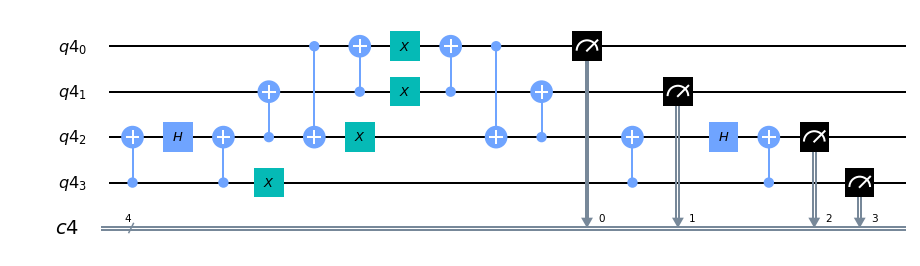

In [53]:
#Setup Quantum System
q4 = QuantumRegister(4)
c4 = ClassicalRegister(4)
qc4 = QuantumCircuit(q4, c4)

#I think that this is encoding everything using hadimar and control x gates

# encode
qc4.cx(q4[3],q4[2])
qc4.h(q4[2])
qc4.cx(q4[3],q4[2])
qc4.cx(q4[2], q4[1])
qc4.cx(q4[0], q4[2])
qc4.cx(q4[1], q4[0])
qc4.x(q4)
qc4.cx(q4[1], q4[0])
qc4.cx(q4[0], q4[2])
qc4.cx(q4[2], q4[1])
qc4.cx(q4[3],q4[2])
qc4.h(q4[2])
qc4.cx(q4[3],q4[2])
qc4.measure(q4, c4)
qc4.draw()
qc4.draw(output="mpl")

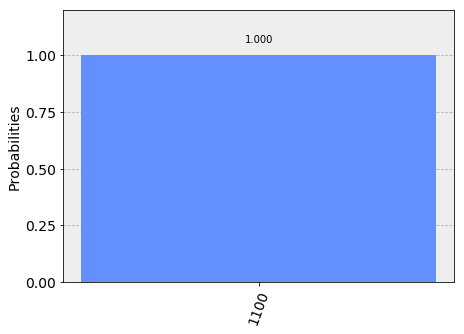

In [54]:
#Simulate
simulator = Aer.get_backend('qasm_simulator')
result = execute(qc4, backend=simulator).result()
plot_histogram(result.get_counts(qc4))

In [66]:
#Run it on a real backend

num_qubits = 3

from qiskit.providers.ibmq import least_busy #Select the least busy device
from qiskit.tools.monitor import job_monitor
possible_devices = provider.backends(filters=lambda x: 
                                     x.configuration().n_qubits >= num_qubits
                                       and 
                                     x.configuration().simulator == False)
qcomp = least_busy(possible_devices)
print(qcomp)

ibmq_vigo


# ibmq_16_melbourne

## This result is not good at all...

Job Status: job has successfully run


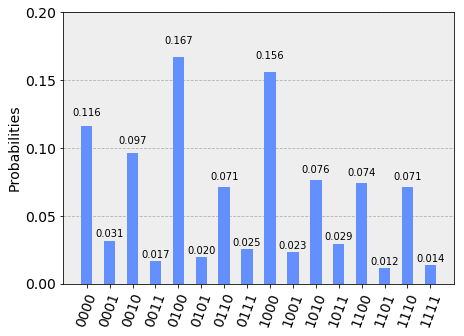

In [57]:
job = execute(qc4, backend=qcomp)
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts(qc4))

# ibmqx2 （Yorktown）

## We got the best result, but there's always a long line waiting for this device

Job Status: job has successfully run


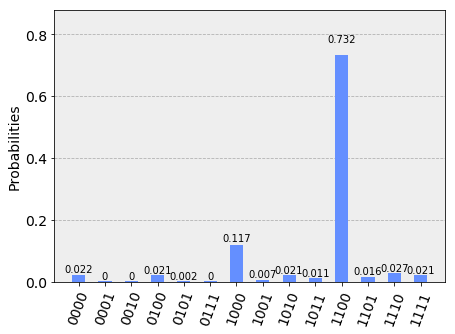

In [63]:
qcomp = provider.get_backend('ibmqx2')
job = execute(qc4, backend=qcomp)
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts(qc4))

# ibmq_vigo

## The result is not the best, but acceptable

Job Status: job has successfully run


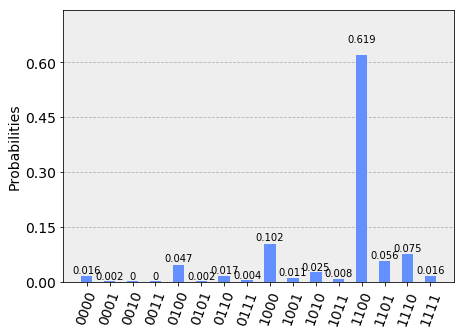

In [65]:
job = execute(qc4, backend=qcomp)
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts(qc4))

Job Status: job has successfully run


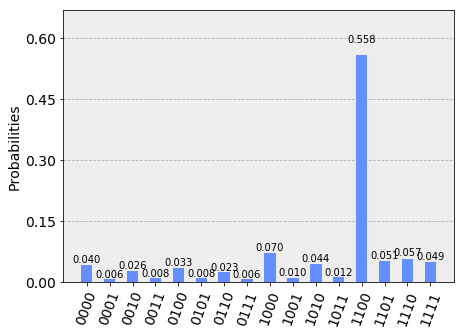

In [67]:
job = execute(qc4, backend=qcomp)
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts(qc4))

Job Status: job has successfully run


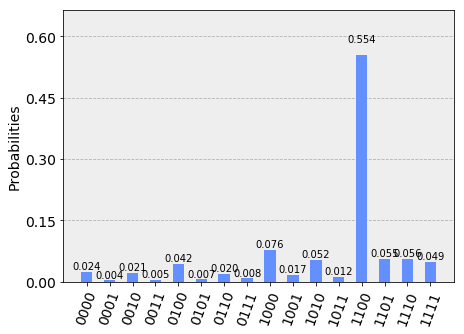

In [68]:
job = execute(qc4, backend=qcomp)
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts(qc4))

Job Status: job has successfully run


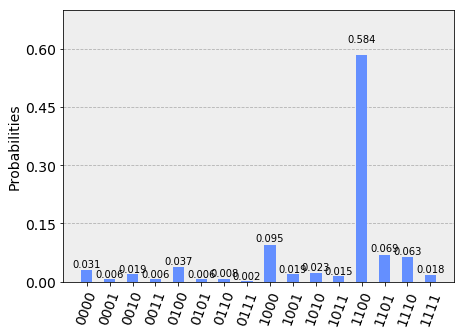

In [69]:
job = execute(qc4, backend=qcomp)
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts(qc4))

# Yorktown, ibmqx2

In [70]:
backend_1 = provider.get_backend('ibmqx2')
backend_2 = provider.get_backend('ibmq_ourense')

job_1 = execute(qc4, backend_1)  
job_2 = execute(qc4, backend_2)  
job_monitor(job_1)
job_monitor(job_2)

Job Status: job has successfully run
Job Status: job has successfully run


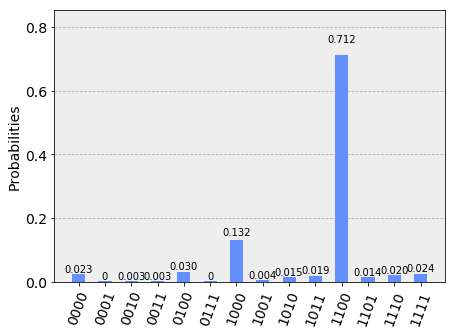

In [76]:
result_1 = job_1.result().get_counts(qc4)
plot_histogram(result_1)

# ibmq_ourense

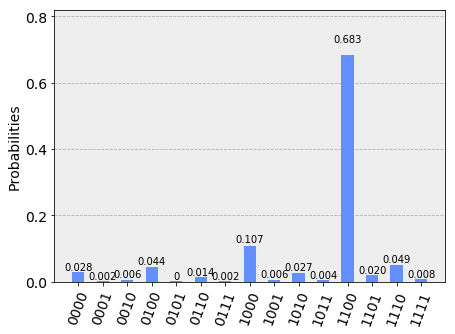

In [74]:
result_2 = job_2.result().get_counts(qc4)
plot_histogram(result_2)